In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing


In [2]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

def filter_optimal(optimal):
    if optimal > 0.5:
        return 1.0
    elif optimal < -0.5:
        return -1.0
    else:
        return 0.0


model = Trading(load_config())

dataset_list = []
for d in model.dfs:
    print(d[1])
    cur_dataset = d[0]
    my_inds = fetchIndicators(["rsi", "macd", "stochastic_oscillator", "optimal_v2", 'slope', 'variance', 'bollinger_bands', 'smma'])
    genDataForAll(cur_dataset, my_inds)
    cur_dataset.dropna(inplace=True)
    mm_scalar = MinMaxScaler()
    cur_dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d"]])
    cur_dataset['optimal'] = cur_dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)
    dataset_list.append(cur_dataset)




XBTUSD
ETHUSD
XRPUSD
LINKUSD
LTCUSD
EOSUSD
ADAUSD
XMRUSD
XLMUSD
TRXUSD
XTZUSD
ATOMUSD
DAIUSD
DASHUSD


In [3]:
final_dataset = pd.concat(dataset_list)

In [4]:


train, test = train_test_split(final_dataset, test_size=0.2, shuffle=False)


<h3>Models</h3>
<p>Random Forest</p>
<p>Fine tuned RF</p>
<p>Gradient boost</p>
<p>GB inside RF</p>
<p>RF inside GB</p>
<p>LSTM</p>

In [5]:

sell_signals = train[train['optimal'] == -1.0]

In [6]:
mean_num_singals = int(len(sell_signals))

In [7]:
not_signals = train[train['optimal'] == 0.0]


In [8]:
print(mean_num_singals, len(not_signals))

122284 5045445


In [9]:
not_signals_sampled = not_signals.sample(n=mean_num_singals * 4, random_state=69420, axis=0)

In [10]:

balanced_data_sell = pd.concat([not_signals_sampled, sell_signals])

In [11]:
filtered_balanced_data_sell = balanced_data_sell[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]



balanced_data_optimal_sell = balanced_data_sell[['optimal']]



In [12]:

clf_sell = RandomForestClassifier(random_state=69420, n_jobs=-1, n_estimators=10)

clf_sell.fit(filtered_balanced_data_sell, balanced_data_optimal_sell)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=69420)

In [13]:


def insert_sells(close, prediction):
    if prediction == -1:
        return close
    else:
        return None

In [14]:
filtered_test = test[["close", "rsi", "MACD", "stosc_k", "stosc_d", "slope", "variance"]]

In [15]:
filtered_test['predict_sell'] = clf_sell.predict(filtered_test.values)

In [16]:
len(filtered_test)

1322549

In [17]:
len(filtered_test[filtered_test['predict_sell'] != 0.0])

304734

In [18]:

filtered_test['sell'] = filtered_test.apply(lambda x: insert_sells(x.close, x.predict_sell), axis=1)

In [29]:
reset_filtered = filtered_test.reset_index(drop=True)

In [30]:
reset_filtered

,close,rsi,MACD,stosc_k,stosc_d,slope,variance,predict_sell,sell
0,0.032654,0.402877,-0.000147,0.658790,0.626029,0.028781,9.399065e-08,0.0,NaN
1,0.032653,0.402877,-0.000145,0.658790,0.624702,0.028781,9.389722e-08,0.0,NaN
2,0.032651,0.402677,-0.000144,0.659735,0.623485,0.028781,9.388996e-08,0.0,NaN
3,0.032651,0.402677,-0.000142,0.659735,0.622021,0.028781,9.388639e-08,0.0,NaN
4,0.032687,0.419882,-0.000139,0.589792,0.620255,0.028781,9.368172e-08,0.0,NaN
...,...,...,...,...,...,...,...,...,...
1322544,68.084301,0.499824,0.086297,0.297025,0.487371,0.013307,2.844701e-01,0.0,NaN
1322545,68.208651,0.503077,0.088162,0.269565,0.485384,0.013307,2.788520e-01,0.0,NaN
1322546,68.178825,0.492841,0.086895,0.353776,0.484393,0.012768,2.734091e-01,0.0,NaN
1322547,68.106913,0.486561,0.083791,0.405950,0.483566,0.012768,2.674625e-01,0.0,NaN


In [43]:
first_amnt = reset_filtered[6000:8000]

<Figure size 432x288 with 0 Axes>

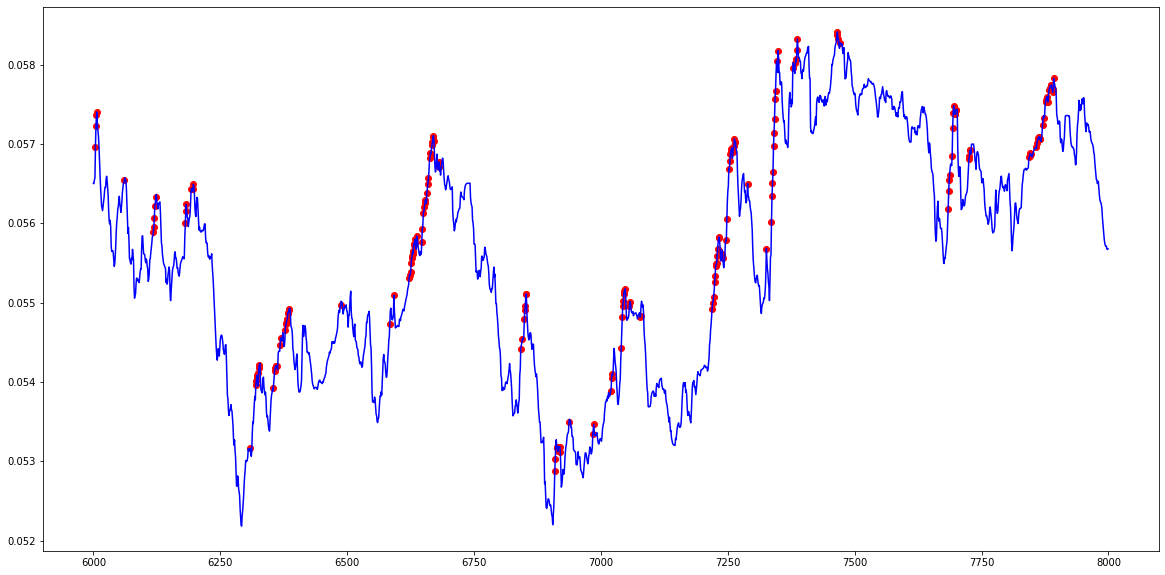

In [44]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='red')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()

In [21]:
import pickle

In [22]:
pickle.dump(clf_sell, open('optimal_v2_sell_rf.sav', 'wb'))

In [28]:
filtered_test

,close,rsi,MACD,stosc_k,stosc_d,slope,variance,predict_sell,sell
111186,0.032654,0.402877,-0.000147,0.658790,0.626029,0.028781,9.399065e-08,0.0,NaN
111187,0.032653,0.402877,-0.000145,0.658790,0.624702,0.028781,9.389722e-08,0.0,NaN
111188,0.032651,0.402677,-0.000144,0.659735,0.623485,0.028781,9.388996e-08,0.0,NaN
111189,0.032651,0.402677,-0.000142,0.659735,0.622021,0.028781,9.388639e-08,0.0,NaN
111190,0.032687,0.419882,-0.000139,0.589792,0.620255,0.028781,9.368172e-08,0.0,NaN
...,...,...,...,...,...,...,...,...,...
256275,68.084301,0.499824,0.086297,0.297025,0.487371,0.013307,2.844701e-01,0.0,NaN
256276,68.208651,0.503077,0.088162,0.269565,0.485384,0.013307,2.788520e-01,0.0,NaN
256277,68.178825,0.492841,0.086895,0.353776,0.484393,0.012768,2.734091e-01,0.0,NaN
256278,68.106913,0.486561,0.083791,0.405950,0.483566,0.012768,2.674625e-01,0.0,NaN
